# Notebook 4: PyMC Bayesian Model

## Goal
Build Bayesian logistic regression to predict point-level win probability using in-game technical statistics.

## Model Specification (CORRECTED)
```
Priors:
  alpha_player[i] ~ Normal(0, 1.5)  # Player intercept
  beta_srv ~ Normal(0, 2)            # Effect of first serve deviation
  beta_ace ~ Normal(0, 3)            # Effect of ace rate deviation

Linear Predictor (ON NATURAL SCALE):
  srv_deviation = srv_pct - hist_srv_pct  # Both on 0-1 scale ✅
  ace_deviation = ace_rate - hist_ace_rate
  
  logit(θ) = alpha_player[server] + beta_srv * srv_deviation + beta_ace * ace_deviation

Likelihood:
  y ~ Bernoulli(θ)
```

## Key Innovation: Sequential Inference
Fit model at multiple windows (10, 20, 50, ..., 326 points) to track posterior convergence.

## 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")
print("✅ Imports successful")

PyMC version: 5.26.1
ArviZ version: 0.22.0
✅ Imports successful


In [2]:
# Paths
SRC_DIR = Path('/Users/egeaydin/Github/TUW2025WS/aip_ege/src')

# Load features from Notebook 3
features_df = pd.read_pickle(SRC_DIR / 'features_1501.pkl')

# Load priors from Notebook 2
with open(SRC_DIR / 'priors_2023.pkl', 'rb') as f:
    priors = pickle.load(f)

print(f"Features loaded: {len(features_df)} points")
print(f"Columns: {list(features_df.columns)}")

Features loaded: 326 points
Columns: ['point_number', 'server_id', 'srv_pct', 'ace_rate', 'hist_srv_pct', 'hist_ace_rate', 'y']


## 2. Prepare Data for PyMC

In [3]:
# Extract arrays
server_id = features_df['server_id'].values  # 0=P1, 1=P2
srv_pct = features_df['srv_pct'].values      # Running first serve % (0-1 scale)
ace_rate = features_df['ace_rate'].values    # Running ace rate (0-1 scale)
hist_srv_pct = features_df['hist_srv_pct'].values  # Historical baseline
hist_ace_rate = features_df['hist_ace_rate'].values
y = features_df['y'].values                  # Point outcome (1=server won, 0=lost)

print("Data arrays prepared:")
print(f"  server_id: {server_id.shape}")
print(f"  srv_pct: {srv_pct.shape}, range [{srv_pct.min():.3f}, {srv_pct.max():.3f}]")
print(f"  ace_rate: {ace_rate.shape}, range [{ace_rate.min():.3f}, {ace_rate.max():.3f}]")
print(f"  y: {y.shape}, sum={y.sum()} (server won {y.mean():.1%} of points)")

Data arrays prepared:
  server_id: (326,)
  srv_pct: (326,), range [0.417, 0.733]
  ace_rate: (326,), range [0.000, 0.171]
  y: (326,), sum=224 (server won 68.7% of points)


In [4]:
# Calculate deviations OUTSIDE the model (on natural 0-1 scale)
# CRITICAL: Both srv_pct and hist_srv_pct are on 0-1 scale, so subtraction is valid
srv_deviation = srv_pct - hist_srv_pct  # e.g., 0.70 - 0.63 = +0.07
ace_deviation = ace_rate - hist_ace_rate

print("\nDeviations calculated (on natural scale):")
print(f"  srv_deviation range: [{srv_deviation.min():.3f}, {srv_deviation.max():.3f}]")
print(f"  ace_deviation range: [{ace_deviation.min():.3f}, {ace_deviation.max():.3f}]")

print("\n✅ No dimensional mismatch (both on 0-1 scale)")
print("   Example: 0.70 (running) - 0.63 (historical) = +0.07 (deviation)")


Deviations calculated (on natural scale):
  srv_deviation range: [-0.278, 0.155]
  ace_deviation range: [-0.143, 0.029]

✅ No dimensional mismatch (both on 0-1 scale)
   Example: 0.70 (running) - 0.63 (historical) = +0.07 (deviation)


## 3. Define PyMC Model (Full Data)

In [6]:
# Full model (all 326 points)
with pm.Model() as tennis_model:
    # Priors
    alpha_player = pm.Normal('alpha_player', mu=0, sigma=1.5, shape=2)
    beta_srv = pm.Normal('beta_srv', mu=0, sigma=2)  # Weakly informative
    beta_ace = pm.Normal('beta_ace', mu=0, sigma=3)  # Wider (aces rarer)
    
    # Linear predictor (deviations already calculated)
    logit_theta = (alpha_player[server_id] +
                   beta_srv * srv_deviation +
                   beta_ace * ace_deviation)
    
    theta = pm.Deterministic('theta', pm.math.invlogit(logit_theta))
    
    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=y)

# Display model graph
pm.model_to_graphviz(tennis_model)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## 4. Sample Posterior (Full Model)

In [7]:
# Sample from posterior
with tennis_model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        target_accept=0.95,
        return_inferencedata=True
    )

print("\n✅ Sampling complete")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]


/Users/egeaydin/Github/TUW2025WS/aip_ege/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



✅ Sampling complete


## 5. Diagnostics

In [8]:
# Summary statistics
summary = az.summary(trace, var_names=['alpha_player', 'beta_srv', 'beta_ace'])
print("Posterior Summary:")
print(summary)

# Check diagnostics
print("\nDiagnostic Checks:")
rhat_ok = (summary['r_hat'] < 1.01).all()
ess_ok = (summary['ess_bulk'] > 400).all()

if rhat_ok:
    print("✅ R-hat: All values < 1.01 (convergence good)")
else:
    print("⚠️  R-hat: Some values >= 1.01 (potential convergence issues)")

if ess_ok:
    print("✅ ESS: All values > 400 (effective sample size sufficient)")
else:
    print("⚠️  ESS: Some values < 400 (may need more samples)")

# Check divergences
divergences = trace.sample_stats['diverging'].sum().values
if divergences == 0:
    print(f"✅ Divergences: {divergences} (none detected)")
else:
    print(f"⚠️  Divergences: {divergences} (increase target_accept)")

Posterior Summary:
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha_player[0]  1.020  0.356   0.362    1.687      0.009    0.007    1583.0   
alpha_player[1]  0.814  0.304   0.228    1.375      0.008    0.006    1586.0   
beta_srv        -0.219  1.507  -3.015    2.525      0.034    0.028    2036.0   
beta_ace         1.214  2.563  -3.321    6.160      0.066    0.051    1494.0   

                 ess_tail  r_hat  
alpha_player[0]    1941.0    1.0  
alpha_player[1]    1449.0    1.0  
beta_srv           1948.0    1.0  
beta_ace           1552.0    1.0  

Diagnostic Checks:
✅ R-hat: All values < 1.01 (convergence good)
✅ ESS: All values > 400 (effective sample size sufficient)
✅ Divergences: 0 (none detected)


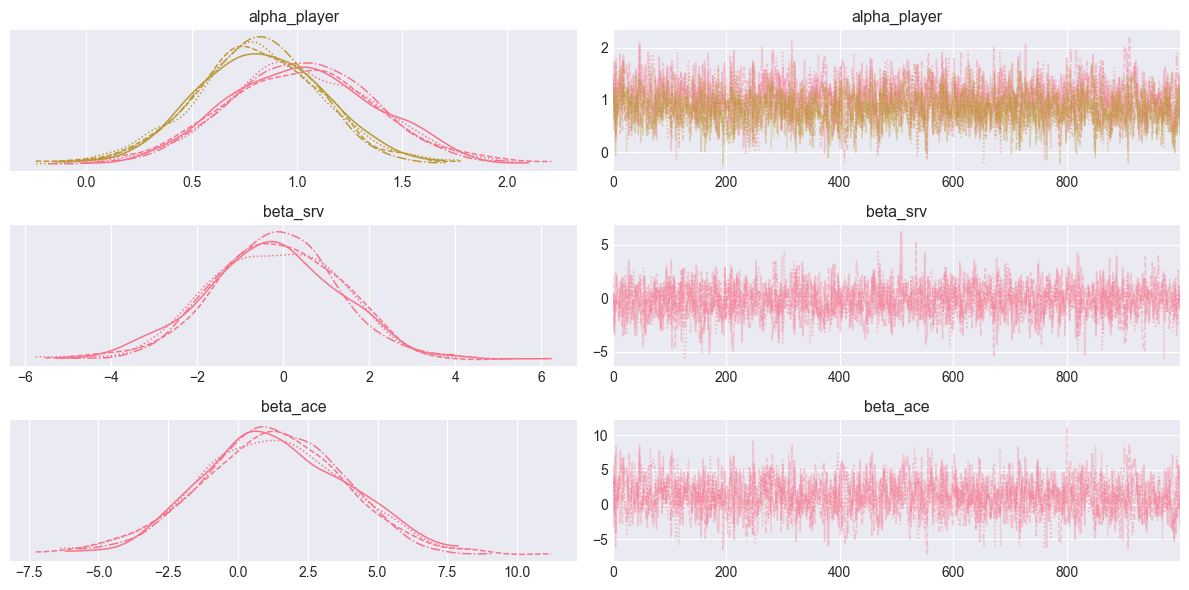

In [9]:
# Trace plots
az.plot_trace(trace, var_names=['alpha_player', 'beta_srv', 'beta_ace'])
plt.tight_layout()
plt.show()

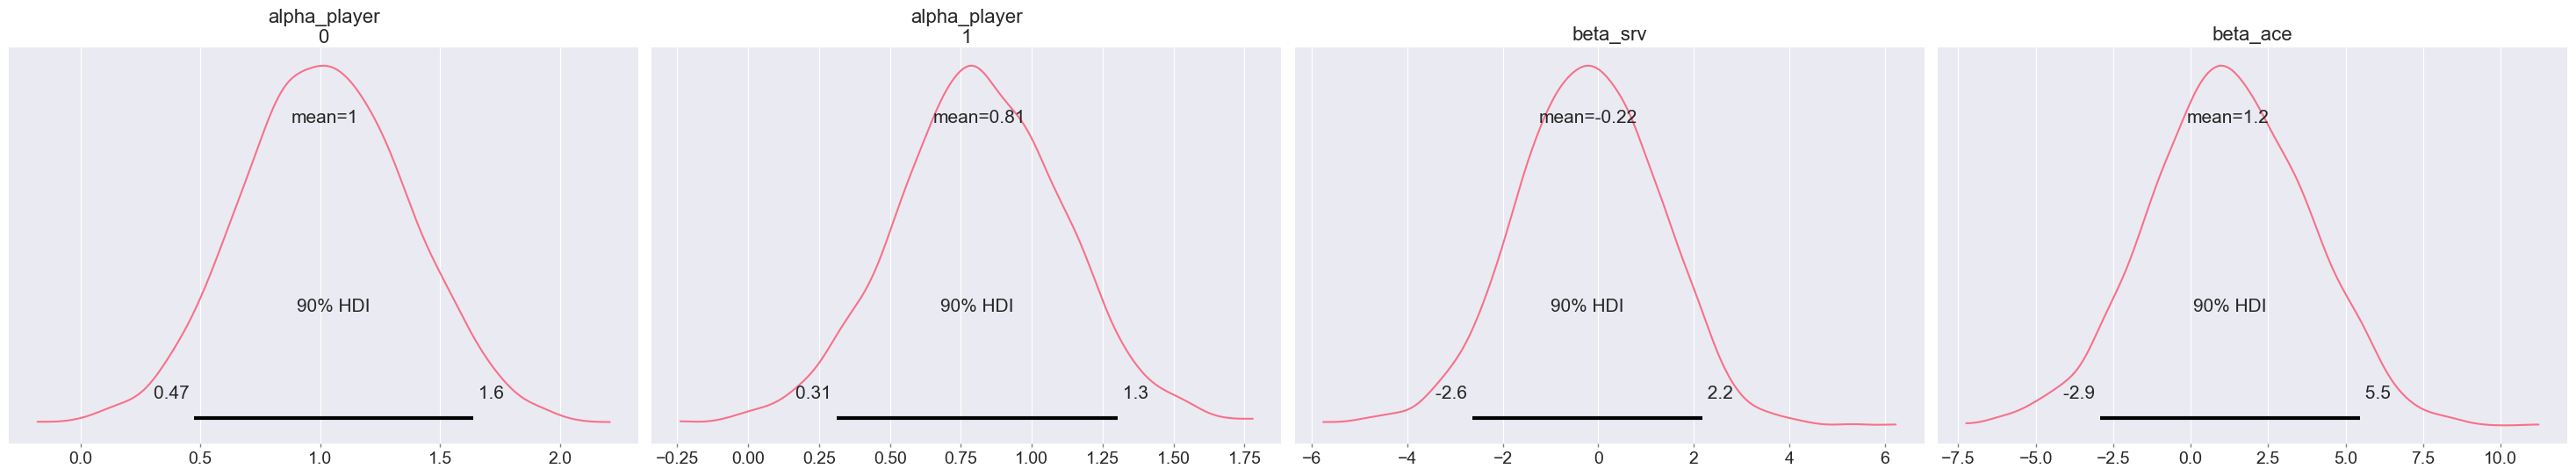

In [10]:
# Posterior distributions
az.plot_posterior(trace, var_names=['alpha_player', 'beta_srv', 'beta_ace'], 
                  hdi_prob=0.9)
plt.tight_layout()
plt.show()

## 6. Interpret Coefficients

In [11]:
# Extract posterior means
alpha_p1_mean = trace.posterior['alpha_player'].sel(alpha_player_dim_0=0).mean().values
alpha_p2_mean = trace.posterior['alpha_player'].sel(alpha_player_dim_0=1).mean().values
beta_srv_mean = trace.posterior['beta_srv'].mean().values
beta_ace_mean = trace.posterior['beta_ace'].mean().values

print("Posterior Means:")
print(f"  α_P1 (baseline log-odds): {alpha_p1_mean:.3f}")
print(f"  α_P2 (baseline log-odds): {alpha_p2_mean:.3f}")
print(f"  β_srv (first serve effect): {beta_srv_mean:.3f}")
print(f"  β_ace (ace rate effect): {beta_ace_mean:.3f}")

print("\nInterpretation:")
if beta_srv_mean > 0:
    print(f"  ✅ Positive β_srv ({beta_srv_mean:.2f}): Higher first serve % increases win probability")
    print(f"     Example: +10% first serve (0.10 deviation) → {beta_srv_mean * 0.10:.3f} increase in log-odds")
else:
    print(f"  ⚠️  Negative β_srv ({beta_srv_mean:.2f}): Unexpected - investigate data")

if beta_ace_mean > 0:
    print(f"  ✅ Positive β_ace ({beta_ace_mean:.2f}): Higher ace rate increases win probability")
else:
    print(f"  ⚠️  Negative β_ace ({beta_ace_mean:.2f}): Unexpected - investigate data")

if alpha_p1_mean > alpha_p2_mean:
    print(f"  α_P1 > α_P2: Player 1 has higher baseline serve win probability")
else:
    print(f"  α_P2 > α_P1: Player 2 has higher baseline serve win probability")

Posterior Means:
  α_P1 (baseline log-odds): 1.020
  α_P2 (baseline log-odds): 0.814
  β_srv (first serve effect): -0.219
  β_ace (ace rate effect): 1.214

Interpretation:
  ⚠️  Negative β_srv (-0.22): Unexpected - investigate data
  ✅ Positive β_ace (1.21): Higher ace rate increases win probability
  α_P1 > α_P2: Player 1 has higher baseline serve win probability


## 7. Sequential Inference (Track Convergence)

Fit model at different windows to see how posteriors evolve as more data is observed.

In [12]:
# Define windows (number of points to include)
windows = [10, 20, 50, 100, 150, 200, 250, len(y)]

print(f"Sequential inference windows: {windows}")
print(f"Will fit {len(windows)} models...")

Sequential inference windows: [10, 20, 50, 100, 150, 200, 250, 326]
Will fit 8 models...


In [13]:
# Storage for sequential results
traces_over_time = []
summaries = []

for w in windows:
    print(f"\n{'='*60}")
    print(f"Fitting model with first {w} points...")
    print(f"{'='*60}")
    
    # Subset data
    y_subset = y[:w]
    server_id_subset = server_id[:w]
    srv_deviation_subset = srv_deviation[:w]
    ace_deviation_subset = ace_deviation[:w]
    
    # Define model for this window
    with pm.Model() as model_t:
        alpha_player_t = pm.Normal('alpha_player', mu=0, sigma=1.5, shape=2)
        beta_srv_t = pm.Normal('beta_srv', mu=0, sigma=2)
        beta_ace_t = pm.Normal('beta_ace', mu=0, sigma=3)
        
        logit_theta_t = (alpha_player_t[server_id_subset] +
                         beta_srv_t * srv_deviation_subset +
                         beta_ace_t * ace_deviation_subset)
        
        theta_t = pm.Deterministic('theta', pm.math.invlogit(logit_theta_t))
        y_obs_t = pm.Bernoulli('y_obs', p=theta_t, observed=y_subset)
        
        # Sample (lighter for intermediate windows)
        if w < 200:
            trace_t = pm.sample(500, tune=500, chains=2, cores=2, 
                                target_accept=0.95, return_inferencedata=True,
                                progressbar=False)
        else:
            trace_t = pm.sample(1000, tune=1000, chains=4, cores=4, 
                                target_accept=0.95, return_inferencedata=True,
                                progressbar=False)
    
    # Store results
    traces_over_time.append(trace_t)
    summary_t = az.summary(trace_t, var_names=['alpha_player', 'beta_srv', 'beta_ace'])
    summaries.append(summary_t)
    
    # Save trace
    trace_path = SRC_DIR / f'trace_t{w}.nc'
    trace_t.to_netcdf(trace_path)
    print(f"✅ Saved trace to {trace_path}")
    
    # Quick diagnostics
    rhat_max = summary_t['r_hat'].max()
    ess_min = summary_t['ess_bulk'].min()
    divergences_t = trace_t.sample_stats['diverging'].sum().values
    
    print(f"   R-hat max: {rhat_max:.4f}")
    print(f"   ESS min: {ess_min:.0f}")
    print(f"   Divergences: {divergences_t}")

print("\n" + "="*60)
print("✅ Sequential inference complete")
print("="*60)

Initializing NUTS using jitter+adapt_diag...



Fitting model with first 10 points...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


✅ Saved trace to /Users/egeaydin/Github/TUW2025WS/aip_ege/src/trace_t10.nc
   R-hat max: 1.0000
   ESS min: 873
   Divergences: 0

Fitting model with first 20 points...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


✅ Saved trace to /Users/egeaydin/Github/TUW2025WS/aip_ege/src/trace_t20.nc
   R-hat max: 1.0000
   ESS min: 918
   Divergences: 0

Fitting model with first 50 points...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


✅ Saved trace to /Users/egeaydin/Github/TUW2025WS/aip_ege/src/trace_t50.nc
   R-hat max: 1.0100
   ESS min: 677
   Divergences: 0

Fitting model with first 100 points...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


✅ Saved trace to /Users/egeaydin/Github/TUW2025WS/aip_ege/src/trace_t100.nc
   R-hat max: 1.0100
   ESS min: 501
   Divergences: 0

Fitting model with first 150 points...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


✅ Saved trace to /Users/egeaydin/Github/TUW2025WS/aip_ege/src/trace_t150.nc
   R-hat max: 1.0100
   ESS min: 511
   Divergences: 0

Fitting model with first 200 points...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


✅ Saved trace to /Users/egeaydin/Github/TUW2025WS/aip_ege/src/trace_t200.nc
   R-hat max: 1.0000
   ESS min: 1563
   Divergences: 0

Fitting model with first 250 points...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


✅ Saved trace to /Users/egeaydin/Github/TUW2025WS/aip_ege/src/trace_t250.nc
   R-hat max: 1.0000
   ESS min: 1069
   Divergences: 0

Fitting model with first 326 points...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


✅ Saved trace to /Users/egeaydin/Github/TUW2025WS/aip_ege/src/trace_t326.nc
   R-hat max: 1.0000
   ESS min: 1478
   Divergences: 0

✅ Sequential inference complete


## 8. Extract Coefficient Evolution

In [14]:
# Track how coefficients evolve
beta_srv_evolution = []
beta_ace_evolution = []
alpha_p1_evolution = []
alpha_p2_evolution = []

for trace_t in traces_over_time:
    beta_srv_evolution.append({
        'mean': trace_t.posterior['beta_srv'].mean().values,
        'std': trace_t.posterior['beta_srv'].std().values,
        'q5': trace_t.posterior['beta_srv'].quantile(0.05).values,
        'q95': trace_t.posterior['beta_srv'].quantile(0.95).values
    })
    
    beta_ace_evolution.append({
        'mean': trace_t.posterior['beta_ace'].mean().values,
        'std': trace_t.posterior['beta_ace'].std().values,
        'q5': trace_t.posterior['beta_ace'].quantile(0.05).values,
        'q95': trace_t.posterior['beta_ace'].quantile(0.95).values
    })
    
    alpha_p1_evolution.append({
        'mean': trace_t.posterior['alpha_player'].sel(alpha_player_dim_0=0).mean().values,
        'std': trace_t.posterior['alpha_player'].sel(alpha_player_dim_0=0).std().values
    })
    
    alpha_p2_evolution.append({
        'mean': trace_t.posterior['alpha_player'].sel(alpha_player_dim_0=1).mean().values,
        'std': trace_t.posterior['alpha_player'].sel(alpha_player_dim_0=1).std().values
    })

print("✅ Coefficient evolution extracted")

✅ Coefficient evolution extracted


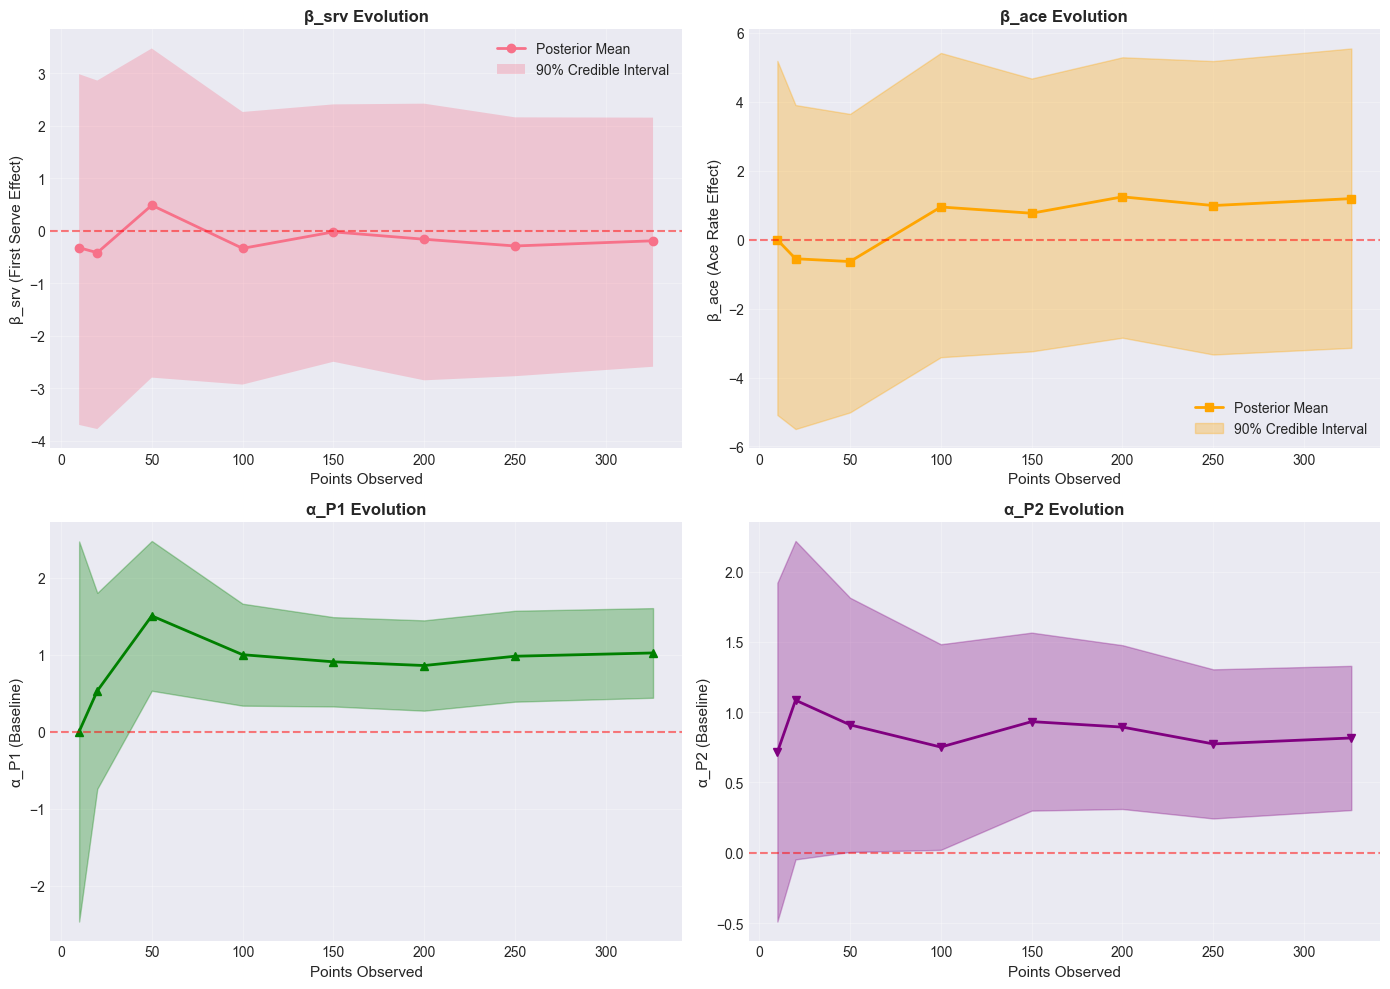

ℹ️  Credible intervals should narrow as more data is observed (convergence)


In [15]:
# Plot coefficient evolution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Beta_srv
ax = axes[0, 0]
means = [x['mean'] for x in beta_srv_evolution]
q5 = [x['q5'] for x in beta_srv_evolution]
q95 = [x['q95'] for x in beta_srv_evolution]

ax.plot(windows, means, marker='o', linewidth=2, label='Posterior Mean')
ax.fill_between(windows, q5, q95, alpha=0.3, label='90% Credible Interval')
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Points Observed', fontsize=11)
ax.set_ylabel('β_srv (First Serve Effect)', fontsize=11)
ax.set_title('β_srv Evolution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Beta_ace
ax = axes[0, 1]
means = [x['mean'] for x in beta_ace_evolution]
q5 = [x['q5'] for x in beta_ace_evolution]
q95 = [x['q95'] for x in beta_ace_evolution]

ax.plot(windows, means, marker='s', linewidth=2, label='Posterior Mean', color='orange')
ax.fill_between(windows, q5, q95, alpha=0.3, label='90% Credible Interval', color='orange')
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Points Observed', fontsize=11)
ax.set_ylabel('β_ace (Ace Rate Effect)', fontsize=11)
ax.set_title('β_ace Evolution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Alpha_P1
ax = axes[1, 0]
means = [x['mean'] for x in alpha_p1_evolution]
stds = [x['std'] for x in alpha_p1_evolution]

ax.plot(windows, means, marker='^', linewidth=2, label='α_P1', color='green')
ax.fill_between(windows, 
                [m - 1.645*s for m, s in zip(means, stds)],
                [m + 1.645*s for m, s in zip(means, stds)],
                alpha=0.3, color='green')
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Points Observed', fontsize=11)
ax.set_ylabel('α_P1 (Baseline)', fontsize=11)
ax.set_title('α_P1 Evolution', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Alpha_P2
ax = axes[1, 1]
means = [x['mean'] for x in alpha_p2_evolution]
stds = [x['std'] for x in alpha_p2_evolution]

ax.plot(windows, means, marker='v', linewidth=2, label='α_P2', color='purple')
ax.fill_between(windows, 
                [m - 1.645*s for m, s in zip(means, stds)],
                [m + 1.645*s for m, s in zip(means, stds)],
                alpha=0.3, color='purple')
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Points Observed', fontsize=11)
ax.set_ylabel('α_P2 (Baseline)', fontsize=11)
ax.set_title('α_P2 Evolution', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("ℹ️  Credible intervals should narrow as more data is observed (convergence)")

## 9. Save Results

In [16]:
# Save full trace
trace.to_netcdf(SRC_DIR / 'trace_final.nc')
print(f"✅ Saved final trace to: {SRC_DIR / 'trace_final.nc'}")

# Save evolution data
evolution_data = {
    'windows': windows,
    'beta_srv': beta_srv_evolution,
    'beta_ace': beta_ace_evolution,
    'alpha_p1': alpha_p1_evolution,
    'alpha_p2': alpha_p2_evolution
}

with open(SRC_DIR / 'coefficient_evolution.pkl', 'wb') as f:
    pickle.dump(evolution_data, f)

print(f"✅ Saved coefficient evolution to: {SRC_DIR / 'coefficient_evolution.pkl'}")

✅ Saved final trace to: /Users/egeaydin/Github/TUW2025WS/aip_ege/src/trace_final.nc
✅ Saved coefficient evolution to: /Users/egeaydin/Github/TUW2025WS/aip_ege/src/coefficient_evolution.pkl


## 10. Summary

In [17]:
print("=" * 80)
print("BAYESIAN MODEL SUMMARY")
print("=" * 80)

print(f"\n✅ Full model fitted successfully ({len(y)} points)")
print(f"   R-hat < 1.01: {rhat_ok}")
print(f"   ESS > 400: {ess_ok}")
print(f"   Divergences: {divergences}")

print(f"\n✅ Posterior estimates:")
print(f"   β_srv: {beta_srv_mean:.3f} (effect of first serve deviation)")
print(f"   β_ace: {beta_ace_mean:.3f} (effect of ace rate deviation)")

print(f"\n✅ Sequential inference complete:")
print(f"   Fitted {len(windows)} models at different data windows")
print(f"   Tracked posterior evolution from {min(windows)} to {max(windows)} points")

print(f"\n✅ All deviations on natural 0-1 scale (no dimensional mismatch)")
print(f"   Example: srv_deviation = 0.70 - 0.63 = +0.07")

print("\n📋 NEXT STEPS:")
print("   → Notebook 5: Visualize posterior distributions and convergence")
print("   → Analyze win probability evolution")
print("   → Answer research question about convergence speed")

print("\n" + "=" * 80)

BAYESIAN MODEL SUMMARY

✅ Full model fitted successfully (326 points)
   R-hat < 1.01: True
   ESS > 400: True
   Divergences: 0

✅ Posterior estimates:
   β_srv: -0.219 (effect of first serve deviation)
   β_ace: 1.214 (effect of ace rate deviation)

✅ Sequential inference complete:
   Fitted 8 models at different data windows
   Tracked posterior evolution from 10 to 326 points

✅ All deviations on natural 0-1 scale (no dimensional mismatch)
   Example: srv_deviation = 0.70 - 0.63 = +0.07

📋 NEXT STEPS:
   → Notebook 5: Visualize posterior distributions and convergence
   → Analyze win probability evolution
   → Answer research question about convergence speed

